# **1. Perkenalan Dataset**


**Sumber Dataset:** https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects

**Tujuan:** Memprediksi apakah suatu pengobatan akan atau Tidak Efektif berdasarkan profil pasien (Umur, Gender, Kondisi) dan dosis obat

**Target Variable:** Mengubah kolom `Improvement_Score` menjadi kelas klasifikasi (1 = Efektif, 0 = Tidak Efektif)

# **2. Import Library**

In [1]:
!pip install opendatasets
!pip install seaborn matplotlib pandas scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# **3. Memuat Dataset**

In [3]:
dataset_url = "https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects"
od.download(dataset_url)

data_dir = './1000-drugs-and-side-effects'
filename = os.listdir(data_dir)[0]
file_path = os.path.join(data_dir, filename)

df = pd.read_csv(file_path)

print(f"Dataset berhasil dimuat dari: {file_path}")
print(f"Jumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}")

df.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nisrinanina
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/palakjain9/1000-drugs-and-side-effects


100%|██████████| 11.8k/11.8k [00:00<00:00, 14.0MB/s]


Dataset berhasil dimuat dari: ./1000-drugs-and-side-effects/real_drug_dataset.csv
Jumlah Baris: 1000, Jumlah Kolom: 9


,Patient_ID,Age,Gender,Condition,Drug_Name,Dosage_mg,Treatment_Duration_days,Side_Effects,Improvement_Score
0,P0001,56,Male,Infection,Ciprofloxacin,50,9,Nausea,8.5
1,P0002,69,Male,Hypertension,Metoprolol,500,24,Tiredness,8.7
2,P0003,46,Female,Depression,Bupropion,100,25,Dry mouth,5.4
3,P0004,32,Male,Diabetes,Glipizide,850,44,Low blood sugar,6.4
4,P0005,60,Male,Depression,Bupropion,850,35,Anxiety,5.3


# **4. Exploratory Data Analysis (EDA)**




--- Info Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               1000 non-null   object 
 1   Age                      1000 non-null   int64  
 2   Gender                   1000 non-null   object 
 3   Condition                1000 non-null   object 
 4   Drug_Name                1000 non-null   object 
 5   Dosage_mg                1000 non-null   int64  
 6   Treatment_Duration_days  1000 non-null   int64  
 7   Side_Effects             1000 non-null   object 
 8   Improvement_Score        1000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB

--- Cek Missing Values ---
Patient_ID                 0
Age                        0
Gender                     0
Condition                  0
Drug_Name                  0
Dosage_mg                  0
Treatment_Dura

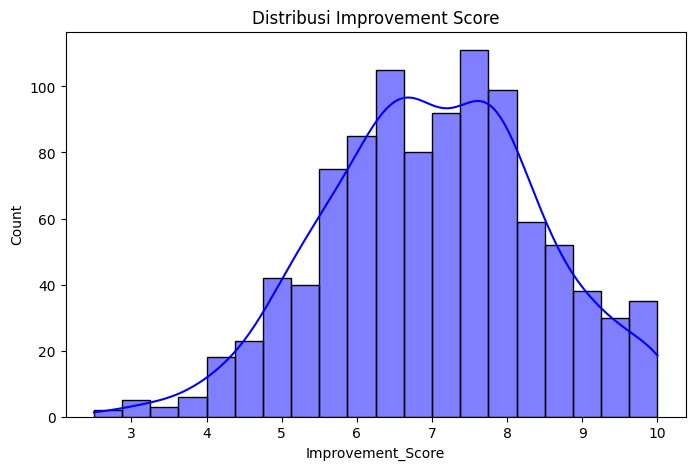

/tmp/ipython-input-1816575622.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='viridis')


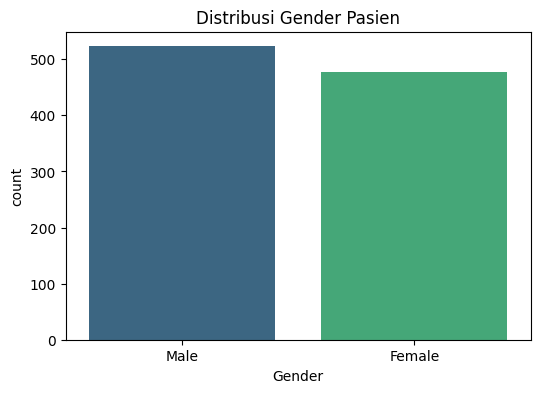

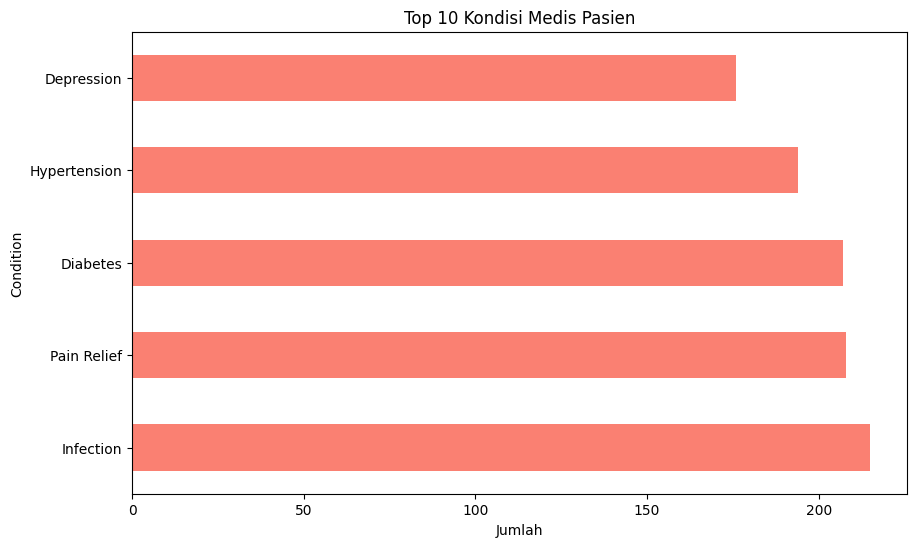

In [4]:
print("\n--- Info Dataset ---")
df.info()

print("\n--- Cek Missing Values ---")
print(df.isnull().sum())

print("\n--- Statistik Deskriptif ---")
print(df.describe())

plt.figure(figsize=(8, 5))
sns.histplot(df['Improvement_Score'], kde=True, color='blue')
plt.title('Distribusi Improvement Score')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=df, palette='viridis')
plt.title('Distribusi Gender Pasien')
plt.show()

plt.figure(figsize=(10, 6))
df['Condition'].value_counts().head(10).plot(kind='barh', color='salmon')
plt.title('Top 10 Kondisi Medis Pasien')
plt.xlabel('Jumlah')
plt.show()

# **5. Data Preprocessing**

1.  **Feature Selection**: Membuang kolom yang tidak relevan (ID, Nama Obat)
2.  **Target Engineering**: Membuat kolom target klasifikasi dari `Improvement_Score`
3.  **Encoding**: Mengubah data kategorikal (Gender, Condition) menjadi angka
4.  **Scaling**: Menyamakan skala data numerik (Age, Dosage)
5.  **Saving**

In [5]:
# --- Feature Selection & Target Engineering ---
df_clean = df.copy()
# Jika Improvement_Score > 50 maka 'Efektif' (1), jika tidak maka 'Tidak Efektif' (0)
df_clean['Effectiveness'] = df_clean['Improvement_Score'].apply(lambda x: 1 if x > 50 else 0)
cols_to_drop = ['Patient_ID', 'Drug_Name', 'Improvement_Score']
df_clean = df_clean.drop(columns=cols_to_drop)
print("Kolom setelah drop:", df_clean.columns)

# --- Encoding Data Kategorikal ---
# A. Label Encoding untuk Gender
le = LabelEncoder()
df_clean['Gender'] = le.fit_transform(df_clean['Gender'])
print("\nGender encoded:", df_clean['Gender'].unique())
# B. One-Hot Encoding untuk Condition & Side_Effects
top_conditions = df['Condition'].value_counts().nlargest(10).index
top_side_effects = df['Side_Effects'].value_counts().nlargest(10).index
df_clean['Condition'] = df_clean['Condition'].apply(lambda x: x if x in top_conditions else 'Other')
df_clean['Side_Effects'] = df_clean['Side_Effects'].apply(lambda x: x if x in top_side_effects else 'Other')
df_clean = pd.get_dummies(df_clean, columns=['Condition', 'Side_Effects'], prefix=['Cond', 'SE'])
bool_cols = [col for col in df_clean.columns if df_clean[col].dtype == 'bool']
df_clean[bool_cols] = df_clean[bool_cols].astype(int)

# --- Scaling Data Numerik ---
scaler = StandardScaler()
numerical_cols = ['Age', 'Dosage_mg', 'Treatment_Duration_days']
df_clean[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

print("\n--- Data Setelah Preprocessing ---")
print(df_clean.head())

# --- Menyimpan Data ---
output_folder = 'namadataset_preprocessing'
os.makedirs(output_folder, exist_ok=True)

# Save to CSV
output_path = os.path.join(output_folder, 'train_clean.csv')
df_clean.to_csv(output_path, index=False)
print(f"\nData berhasil disimpan di: {output_path}")

Kolom setelah drop: Index(['Age', 'Gender', 'Condition', 'Dosage_mg', 'Treatment_Duration_days',
       'Side_Effects', 'Effectiveness'],
      dtype='object')

Gender encoded: [1 0]

--- Data Setelah Preprocessing ---
        Age  Gender  Dosage_mg  Treatment_Duration_days  Effectiveness  \
0  0.339295       1  -1.024988                -1.490098              0   
1  1.057320       1   0.499032                -0.534090              0   
2 -0.213033       0  -0.855652                -0.470356              0   
3 -0.986291       1   1.684380                 0.740588              0   
4  0.560226       1   1.684380                 0.166983              0   

   Cond_Depression  Cond_Diabetes  Cond_Hypertension  Cond_Infection  \
0                0              0                  0               1   
1                0              0                  1               0   
2                1              0                  0               0   
3                0              1               